In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
from numpy.ma.core import resize
from scipy.stats import t
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import pyextremes as pyx
from arch import arch_model
from statsmodels.stats.diagnostic import (acorr_ljungbox)
import statsmodels.api as sm

In [4]:
def get_doge_data():
    doge_yf = yf.download("DOGE-USD", start="2014-01-01", interval="1d")
    print(doge_yf)

    doge_data = pd.read_csv("doge_data.csv")
    doge_data['Date'] = pd.to_datetime(doge_data['Timestamp'])
    print(doge_data)

    result_dataset = pd.DataFrame()
    for i in range(0, len(doge_data)):
        # print(doge_data.iloc[i])
        if (doge_data.iloc[i]['Date'] < pd.to_datetime('2017-11-09 00:00:00.000')):
            new_entry = {'Date': doge_data.iloc[i]['Date'], 'Price': doge_data.iloc[i]['Price']}
            result_dataset = pd.concat([result_dataset, pd.DataFrame([new_entry])], ignore_index=True)

    doge_yf = doge_yf.reset_index()

    # Now select only the 'Date' and 'Close' columns
    doge_date_close = doge_yf[['Date', 'Close']]
    doge_date_close.columns = doge_date_close.columns.droplevel(level=1)
    print(doge_date_close.head())

    for i in range(0, len(doge_date_close)):
        new_entry = {'Date': doge_date_close.iloc[i]['Date'], 'Price': doge_date_close.iloc[i]['Close']}
        # print(new_entry)
        result_dataset = pd.concat([result_dataset, pd.DataFrame([new_entry])], ignore_index=True)

    current = pd.to_datetime('2013-12-15 00:00:00.00')
    cnt = 0
    print(len(result_dataset))
    for i in range(0, len(result_dataset)):
        if (result_dataset.iloc[i]['Date'] != current):
            cnt += 1
            i -= 1
            print(current)
        current = current + pd.Timedelta(days=1)
    print(cnt)
    result_dataset.to_csv('doge_daily_data.csv', index=False)
    print(result_dataset)

get_doge_data()

[*********************100%***********************]  1 of 1 completed


Price          Close      High       Low      Open      Volume
Ticker      DOGE-USD  DOGE-USD  DOGE-USD  DOGE-USD    DOGE-USD
Date                                                          
2017-11-09  0.001415  0.001415  0.001181  0.001207     6259550
2017-11-10  0.001163  0.001431  0.001125  0.001421     4246520
2017-11-11  0.001201  0.001257  0.001141  0.001146     2231080
2017-11-12  0.001038  0.001210  0.001002  0.001189     3288960
2017-11-13  0.001211  0.001212  0.001019  0.001046     2481270
...              ...       ...       ...       ...         ...
2025-05-31  0.192579  0.195352  0.186063  0.193442  1529424800
2025-06-01  0.193632  0.194780  0.187268  0.192578   939280532
2025-06-02  0.195390  0.196065  0.188872  0.193632  1007324701
2025-06-03  0.193138  0.200251  0.192190  0.195396  1062603805
2025-06-04  0.191375  0.196810  0.190368  0.193152   857660992

[2765 rows x 5 columns]
                    Timestamp     Price        Volume    Market Cap       Date
0     2013-12-

               Price
Date                
2013-12-15  0.000559
2013-12-17  0.000218
2013-12-18  0.000268
2013-12-19  0.000475
2013-12-20  0.000989
Iteration:      5,   Func. Count:     32,   Neg. LLF: 13230.181336732032
Iteration:     10,   Func. Count:     61,   Neg. LLF: 13020.597031444433
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13020.597017740974
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -13020.6
Distribution:                  Normal   AIC:                           26049.2
Method:            Maximum Likelihood   BIC:                           26074.6
                       

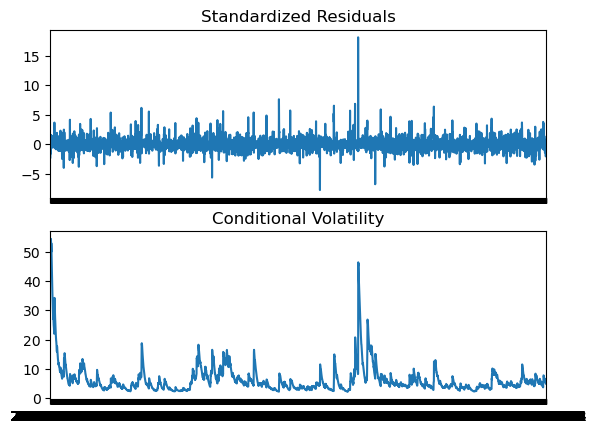

Ljung-Box test on residuals:
    lb_stat  lb_pvalue
1  0.961703   0.326758
Ljung-Box test on squared residuals:
    lb_stat  lb_pvalue
1  2.477208   0.115507
Model is adequate (no remaining ARCH effects).


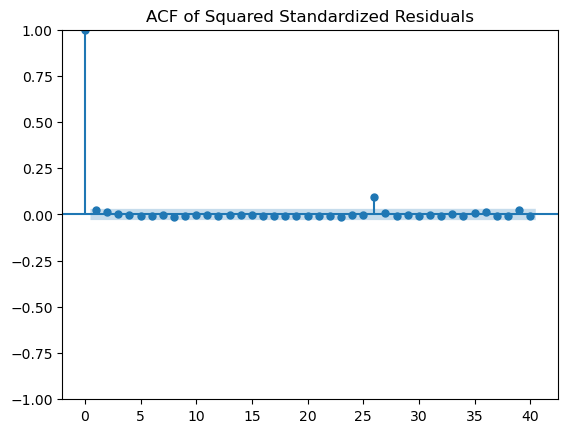

In [11]:
doge_data = pd.read_csv("doge_daily_data.csv")
doge_data.set_index("Date", inplace=True)
print(doge_data.head())

#print(doge_data.head())
# doge_dataaa = yf.download("WMT", start="2008-01-01", end="2013-01-01")['Close'] #S&P 500
log_returns = 100 * np.log(doge_data / doge_data.shift(1)).dropna()

# Step 3: Fit GARCH(1,1) model
model = arch_model(log_returns, vol='Garch', p=1, q=1, mean="Constant")
results = model.fit(update_freq = 5)
print(results.summary())
results.plot()
plt.show()

# Standardized residuals
standardized_resid = results.resid / results.conditional_volatility

# Ljung-Box test (lag 10 as example)
ljung_box = acorr_ljungbox(standardized_resid, lags=1, return_df=True)
print("Ljung-Box test on residuals:")
print(ljung_box)

squared_resid = standardized_resid**2
lb_test_squared = acorr_ljungbox(squared_resid, lags=1, return_df=True)
print("Ljung-Box test on squared residuals:")
print(lb_test_squared)

if lb_test_squared["lb_pvalue"].iloc[0] > 0.05:
    print("Model is adequate (no remaining ARCH effects).")
else:
    print("Model is inadequate (try EGARCH or higher-order GARCH).")

# Step 3: Plot ACF
sm.graphics.tsa.plot_acf(squared_resid, lags=40)
plt.title('ACF of Squared Standardized Residuals')
plt.show()

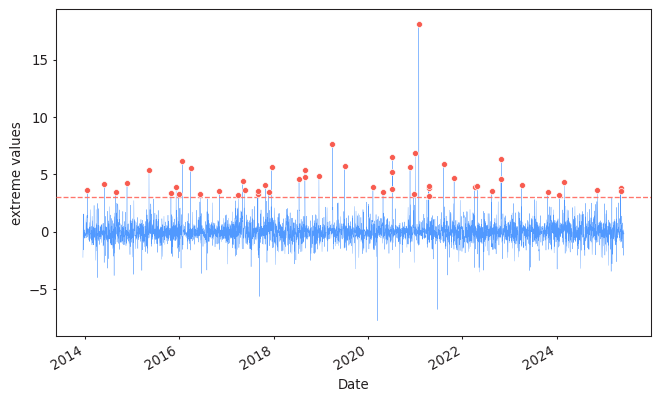

{'c': 0.14039185188782943, 'scale': 1.3775596626350424}


In [ ]:
# Get conditional volatility (sigma_t)
cond_vol = results.conditional_volatility / 100  # Rescale back

# Get standardized residuals (z_t = returns_t / sigma_t)
std_resid = results.resid / results.conditional_volatility

std_resid.index = pd.to_datetime(std_resid.index)


def peaks_over_threshold(data, threshold):
    extremes = pyx.get_extremes(data, "POT", threshold=threshold, r="12h") #r: min time distance between adjacent clusters
    pyx.plotting.plot_extremes(
        ts=data,
        extremes=extremes,
        extremes_method="POT",
        extremes_type="high",
        threshold=threshold,
        r="12h",
    )
    plt.show()
    model = pyx.EVA(data=data)
peaks_over_threshold(std_resid, 3)

extremes = pyx.get_extremes(std_resid, method="POT", threshold=3, r="12h")
model = pyx.EVA(data=std_resid)
model.get_extremes(method="POT", threshold=3, r="12h")
model.fit_model(distribution="genpareto")

# Extract GPD parameters (shape ξ, scale β)
print(model.model.fit_parameters)
shape = model.model.fit_parameters['c']
scale = model.model.fit_parameters['scale']


alpha = 0.05  # 95% confidence
n = len(std_resid)
Nu = len(extremes)  # Number of exceedances

# VaR for standardized residuals
var_Z = u + (scale / shape) * (((n / Nu) * (1 - alpha)) ** (-shape) - 1)

# ES for standardized residuals
es_Z = (var_Z + scale - shape * u) / (1 - shape)

print(f"Standardized Residuals 95% VaR: {var_Z:.4f}")
print(f"Standardized Residuals 95% ES: {es_Z:.4f}")
